In [16]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from nltk.corpus import stopwords
import string
import ssl
import gensim
import sys
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning

# Fix the Dataset Format issue

After browsing the dataset, some reviews seem contain carriage returns (new lines) within the text, while each drug review is supposed to be in a single row. These cause the review to break into multiple rows, making the dataset inconsistent and difficult to process.


**Major formatting issues:**

1. Multi-line Reviews Were Split

Some drug reviews contained line breaks (\n), causing them to be treated as separate rows instead of part of the same review.

2. Misplaced Data in Additional Rows

Some rows contained only review text, without drugName or condition, which made it unclear where they belonged.
Some rows contained misplaced rating, date, and usefulCount values, which were intended for the previous row.


3. Incorrect Merging of Different Drug Entries

Without proper detection, separate drug reviews were accidentally merged together, leading to incorrect data.

In [17]:
# Read the dataset
with open("datasets/drugsCom_raw.tsv", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Initialize variables
fixed_data = []
current_row = None  # Track the last valid row

# Process each line
for line in lines:
    parts = line.strip().split("\t")  # Adjust delimiter if needed

    # Case 1: A complete row with all necessary columns, including usefulCount
    if len(parts) >= 6 and parts[-1].strip() and parts[0] != "drugName":  # Ensure we don't duplicate headers
        if current_row:
            fixed_data.append(current_row)
        current_row = parts  # Start a new row

    # Case 2: A row missing rating, date, and usefulCount (only drugName, condition, and review)
    elif len(parts) == 3:
        if current_row:
            fixed_data.append(current_row)
        current_row = parts + ["", "", ""]  # Fill missing values

    # Case 3: A row that only has the review column
    elif len(parts) == 1 and current_row:
        current_row[2] += " " + parts[0]  # Append to review column

    # Case 4: A row with `drugName, condition, review, rating` but missing date and usefulCount
    elif len(parts) == 4 and current_row:
        current_row[2] += " " + parts[0]  # Merge drugName into review
        current_row[3] = parts[1]  # Assign rating
        current_row[4] = parts[2]  # Assign date
        current_row[5] = parts[3]  # Assign usefulCount

# Append the last processed row
if current_row:
    fixed_data.append(current_row)

# Convert to a DataFrame
df_fixed = pd.DataFrame(fixed_data, columns=["drugName", "condition", "review", "rating", "date", "usefulCount"])

# **Ensure header is written only once**
df_fixed.to_csv("raw_drugs_dataset.csv", index=False)

print("Dataset cleaned successfully. Check 'raw_drugs_dataset.csv'.")


Dataset cleaned successfully. Check 'raw_drugs_dataset.csv'.


# Check the basic information of this dataset

In [18]:
df = pd.read_csv("raw_drugs_dataset.csv")

In [19]:
df.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""""""It has no side effect, I take it in combina...",9.0,"May 20, 2012",27.0
1,Guanfacine,ADHD,"""""""My son is halfway through his fourth week o...",8.0,"April 27, 2010",192.0
2,Lybrel,Birth Control,"""""""I used to take another oral contraceptive, ...",5.0,"December 14, 2009",17.0
3,Ortho Evra,Birth Control,"""""""This is my first time using any form of bir...",8.0,"November 3, 2015",10.0
4,Buprenorphine / naloxone,Opiate Dependence,"""""""Suboxone has completely turned my life arou...",9.0,"November 27, 2016",37.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215066 entries, 0 to 215065
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     215066 non-null  object 
 1   condition    213872 non-null  object 
 2   review       215066 non-null  object 
 3   rating       215058 non-null  float64
 4   date         215058 non-null  object 
 5   usefulCount  215058 non-null  float64
dtypes: float64(2), object(4)
memory usage: 9.8+ MB


In [21]:
df.describe()

,rating,usefulCount
count,215058.000000,215058.000000
mean,6.990058,28.000144
std,3.275511,36.344556
min,1.000000,0.000000
25%,5.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,1291.000000


# Data Cleaning and Preparation

## Handle the abnormal value

In [22]:
# check the missing value
print(df.isnull().sum())

drugName          0
condition      1194
review            0
rating            8
date              8
usefulCount       8
dtype: int64


In [23]:
# Checking the distribution of missing values, are they concentrated in certain drug types?
df[df['condition'].isnull()]['drugName'].value_counts().head(15)

drugName
Ethinyl estradiol / norethindrone                          134
Ethinyl estradiol / norgestimate                           108
Ethinyl estradiol / levonorgestrel                         103
Drospirenone / ethinyl estradiol                            44
Medroxyprogesterone                                         35
Levonorgestrel                                              34
Etonogestrel                                                19
Drospirenone / ethinyl estradiol / levomefolate calcium     16
Amphetamine / dextroamphetamine                             14
Desogestrel / ethinyl estradiol                             12
Quetiapine                                                  11
Pregabalin                                                  11
Vilazodone                                                  11
Methylphenidate                                             10
Bupropion                                                    9
Name: count, dtype: int64

As we can search the information of these drugs, the missing condition values appear to be **concentrated among hormonal contraceptives and psychiatric medications**.

1. Hormonal Contraceptives & Birth Control

Ethinyl estradiol combinations (e.g., with norethindrone, norgestimate, levonorgestrel, drospirenone, etonogestrel, desogestrel) dominate the missing values.
This suggests that many birth control users might not have specified a condition, assuming that **birth control is self-explanatory**.

2. Psychiatric & Neurological Medications

Amphetamine / dextroamphetamine (ADHD medication)
Quetiapine (antipsychotic)
Pregabalin (nerve pain, epilepsy, anxiety)
Vilazodone & Bupropion (antidepressants)
Methylphenidate (ADHD stimulant)
These medications **treat multiple conditions**.

Thus, the missing values could be filled with "Unknown".

In [24]:
# fill missing values in 'condition' with "Unknown"
df['condition'].fillna("Unknown", inplace=True)

/var/folders/c2/m991tq7927q0f_s81l33swg80000gn/T/ipykernel_80944/2793071500.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['condition'].fillna("Unknown", inplace=True)


In [25]:
df = df.dropna(subset=["date"]).reset_index(drop=True)

In [26]:
# verify that missing values are handled
print(df.isnull().sum())

drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64


## Handle the HTML artifacts

The "review" column contains HTML artifacts, use decode function to extract and return only the plain text, removing any HTML tags or entities.

In [27]:
def decode_html(text):
    decoded_text = BeautifulSoup(text, "html.parser").get_text()
    return decoded_text

# Applying the function to the review column
df["review"]= df["review"].apply(decode_html)

After browsing the dataset, I found the "condition" column contains HTML artifacts or parsing errors where the text includes "users found this comment helpful." instead of actual condition names. These rows should be removed.

In [28]:
# Remove rows where 'condition' contains HTML artifacts
df = df[~df['condition'].str.contains("users found this comment helpful", na=False)]

In [29]:
# check if clean
invalid_conditions = df[df['condition'].str.contains("users found this comment helpful", na=False)]
print(invalid_conditions[['condition', 'drugName', 'rating']])

Empty DataFrame
Columns: [condition, drugName, rating]
Index: []


## Convert Date Format

Convert the "date" column to datetime format.

In [30]:
print(df["date"].head(10))  # View a sample of the date column

0         May 20, 2012
1       April 27, 2010
2    December 14, 2009
3     November 3, 2015
4    November 27, 2016
5    November 28, 2015
6        March 7, 2017
7       March 14, 2015
8       August 9, 2016
9     December 8, 2016
Name: date, dtype: object


In [31]:
# Convert the "date" column to datetime format in the training and testing datasets
df["date"]= pd.to_datetime(df["date"], format="%B %d, %Y")

In [32]:
## Extracting day, month, and year into separate columns
df["day"] = df["date"].dt.day.astype("int8")
df["month"] = df["date"].dt.month.astype("int8")
df["year"] = df["date"].dt.year.astype("int16")

In [33]:
df.head(20)

,drugName,condition,review,rating,date,usefulCount,day,month,year
0,Valsartan,Left Ventricular Dysfunction,"""""""It has no side effect, I take it in combina...",9.0,2012-05-20,27.0,20,5,2012
1,Guanfacine,ADHD,"""""""My son is halfway through his fourth week o...",8.0,2010-04-27,192.0,27,4,2010
2,Lybrel,Birth Control,"""""""I used to take another oral contraceptive, ...",5.0,2009-12-14,17.0,14,12,2009
3,Ortho Evra,Birth Control,"""""""This is my first time using any form of bir...",8.0,2015-11-03,10.0,3,11,2015
4,Buprenorphine / naloxone,Opiate Dependence,"""""""Suboxone has completely turned my life arou...",9.0,2016-11-27,37.0,27,11,2016
5,Cialis,Benign Prostatic Hyperplasia,"""""""2nd day on 5mg started to work with rock ha...",2.0,2015-11-28,43.0,28,11,2015
6,Levonorgestrel,Emergency Contraception,"""""""He pulled out, but he cummed a bit in me. I...",1.0,2017-03-07,5.0,7,3,2017
7,Aripiprazole,Bipolar Disorde,"""""""Abilify changed my life. There is hope. I w...",10.0,2015-03-14,32.0,14,3,2015
8,Keppra,Epilepsy,""""""" I Ve had nothing but problems with the Ke...",1.0,2016-08-09,11.0,9,8,2016
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""""""I had been on the pill for many years. When...",8.0,2016-12-08,1.0,8,12,2016


## HTML Decoding

In [34]:
# function to decode HTML-encoded characters
def decode_html(text):
    decoded_text = BeautifulSoup(text, "html.parser").get_text()
    return decoded_text

In [35]:
# Applying the function to the review column
df["review"] = df["review"].apply(decode_html)

## Store the Cleaned Dataset

In [36]:
df.to_csv("clean_drug_data.csv", index=False)

# Explore Ratings

## Explore the distribution of ratings

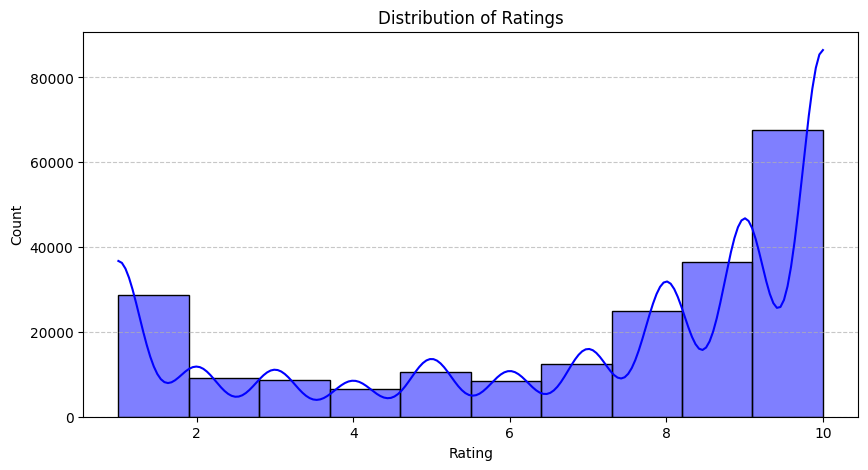

In [37]:
# explore the distribution of ratings
plt.figure(figsize=(10,5))
sns.histplot(df['rating'], bins=10, kde=True, color='blue')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**Insights for the Distribution of Ratings**

There are two peaks: One at 1-2 ratings and another at 9-10 ratings.
This suggests that reviews are polarized, **users tend to love or hate the drugs**, rather than giving neutral ratings.

The highest counts are at rating 10, followed by 8 and 9.
This implies that **most users have a positive experience with their medications**.

A noticeable spike at 1-2 ratings suggests that **some users had very bad experiences with certain drugs**.
The reason could be severe side effects or inefficacy.

## Highest vs. Lowest-rated Conditions
Many rare conditions may have a small number of reviews leading to artificially high averages, thus, simply calculating the top several highest ratings which only have few reviews is meaningless. 

Then we can filter out conditions with fewer than 30 reviews to focus on more reliable ratings. 

We plot the highest vs. lowest-rated conditions side by side, instead of only showing the highest-rated conditions.

/var/folders/c2/m991tq7927q0f_s81l33swg80000gn/T/ipykernel_80944/3183740761.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=balanced_ratings.values, y=balanced_ratings.index, palette="coolwarm")


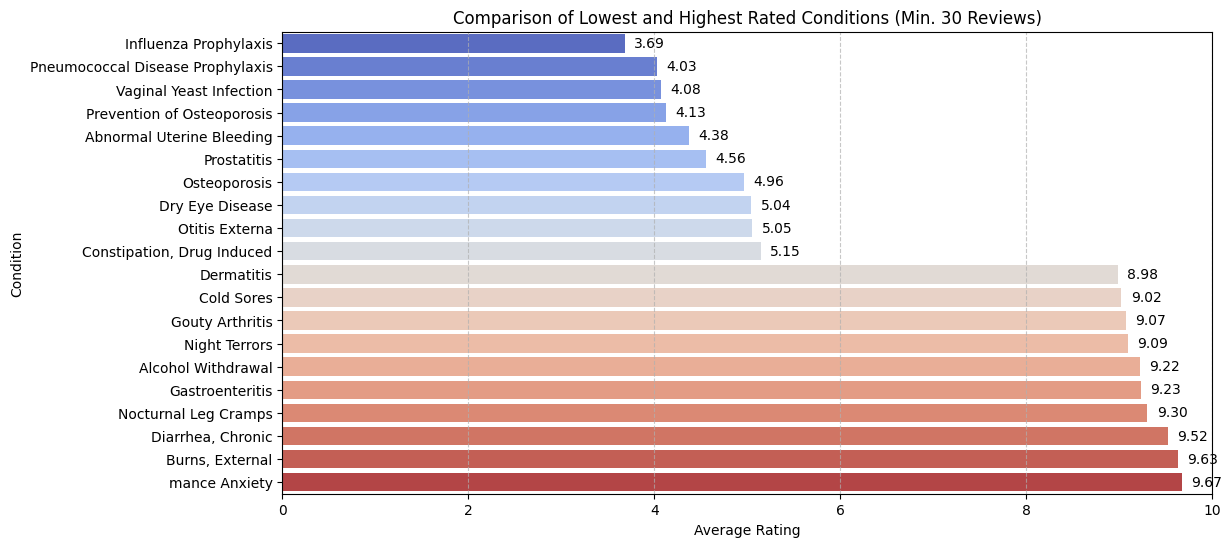

In [38]:
# filter out conditions less than 30 reviews
condition_counts = df['condition'].value_counts()
valid_conditions = condition_counts[condition_counts >= 30].index
filtered_df = df[df['condition'].isin(valid_conditions)]

# compute average ratings for valid conditions
condition_ratings = filtered_df.groupby("condition")["rating"].mean().sort_values()

# select bottom 10 and top 10 conditions
lowest_rated = condition_ratings.head(10)
highest_rated = condition_ratings.tail(10)

balanced_ratings = pd.concat([lowest_rated, highest_rated])

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x=balanced_ratings.values, y=balanced_ratings.index, palette="coolwarm")

for i, v in enumerate(balanced_ratings.values):
    ax.text(v + 0.1, i, f"{v:.2f}", va='center', fontsize=10, color='black')

plt.xlabel("Average Rating")
plt.ylabel("Condition")
plt.title("Comparison of Lowest and Highest Rated Conditions (Min. 30 Reviews)")
plt.xlim(0, 10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()



**Insights of Lowest Rated Conditions**
1. **Vaccination-related conditions have the lowest ratings**
   - Vaccination-related conditions such as Influenza Prophylaxis (3.69) & Pneumococcal Disease Prophylaxis (4.03) have the lowest ratings.
   - Could be due to **side effects** or **lack of immediate noticeable benefits**, since vaccines are preventive, not curative.
   - Guess: Do users misunderstand how vaccines work, leading to lower satisfaction?

2. **Chronic conditions have lower ratings**
   - These conditions (e.g., Vaginal Yeast Infection (4.08), Prevention of Osteoporosis (4.13), Abnormal Uterine Bleeding (4.38), Prostatitis (4.56))often require **long-term management**, leading to **frustration with medication effectiveness**.
   - Guess1: **Side effects** may play a role in lower satisfaction.
   - Guess2: Patients might have high expectations for relief but experience only **partial symptom control**.

3. **Female-specific conditions with low ratings**
   - Female-specific conditions (e.g., Vaginal Yeast Infection (4.08), Abnormal Uterine Bleeding (4.38)) have hormonal treatments with unwanted side effects.
   - Guess1: Women’s health concerns are often understudied or dismissed in medical settings (Many medications are tested primarily on men, leading to less effective treatments for female-specific conditions) may be the reason.

**Insights of Highest Rated Conditions**
1. **Conditions have quick-relief treatments have higher ratings**
   - Performance Anxiety (9.67) & Burns, External (9.68) are more likely to receive high satisfaction ratings because of **immediate relief**.

2. **Highly treatable conditions have high ratings**
   - **Highly treatable conditions** (e.g., Diarrhea, Chronic (9.52) & Nocturnal Leg Cramps (9.30)) where medication offers **clear and noticeable improvements**.

3. **Conditions with severe symptoms have high ratings**
   - Medications for these conditions often **address severe symptoms quickly**, contributing to high ratings.

# Analyzing Popular Drugs & Conditions

## Find which conditions have the most reviews.

In [39]:
# Count the number of reviews per condition
most_reviewed_conditions = df['condition'].value_counts().head(15)

most_reviewed_df = most_reviewed_conditions.reset_index()
most_reviewed_df.columns = ["Condition", "Review Count"]

print(most_reviewed_df)

                    Condition  Review Count
0               Birth Control         38436
1                  Depression         12163
2                        Pain          8245
3                     Anxiety          7812
4                        Acne          7435
5             Bipolar Disorde          5604
6                    Insomnia          4904
7                 Weight Loss          4857
8                     Obesity          4757
9                        ADHD          4509
10           Diabetes, Type 2          3362
11    Emergency Contraception          3290
12        High Blood Pressure          3104
13    Vaginal Yeast Infection          3085
14  Abnormal Uterine Bleeding          2744


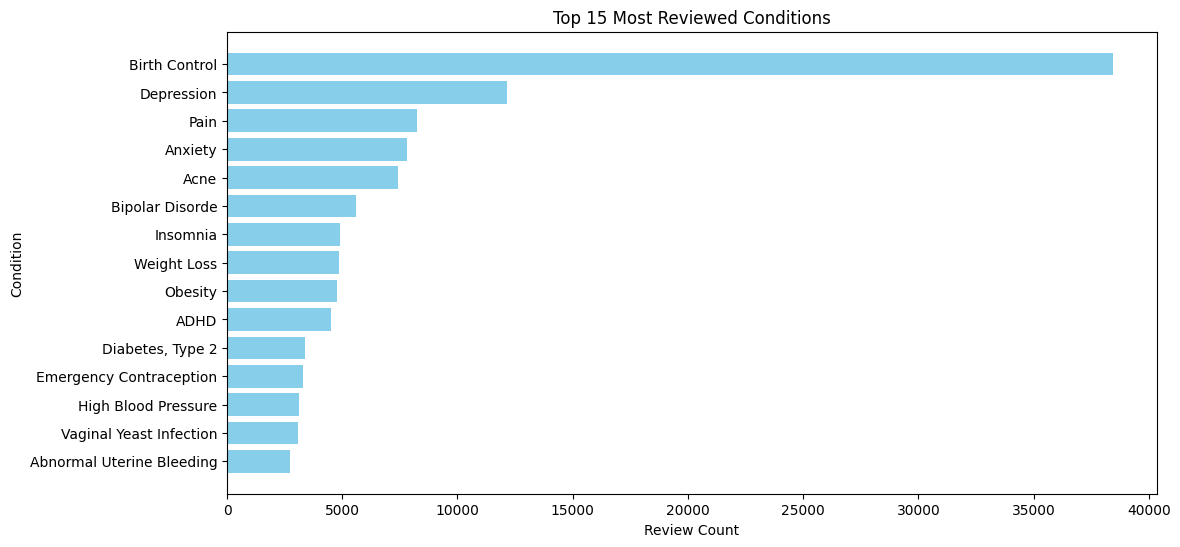

In [40]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(most_reviewed_df["Condition"], most_reviewed_df["Review Count"], color='skyblue')
plt.xlabel("Review Count")
plt.ylabel("Condition")
plt.title("Top 15 Most Reviewed Conditions")
plt.gca().invert_yaxis()  # Highest count on top
plt.show()

#### **Insights of the Most Reviewed Conditions**
1. **Birth Control (38,436 reviews) is most-reviewed category.**

    **Guessed reason**: Many women use different brands and formulations. People frequently switch medications due to side effects.

    **Questions**: Does this suggest that women’s health topics drive more engagement on review platforms?
2. **4 of the top 10 conditions relate to mental health (Depression, Anxiety, Bipolar Disorder, ADHD).**

    **Guessed Reason**: Trial-and-error nature of psychiatric medications. Severe side effects usually bother users. Patients relying on peer experiences to find the best treatment.

    **Question:** Do users feel doctors don’t provide enough guidance, leading them to online reviews?

3. **Chronic conditions & pain management have many reviews.**

    Pain & Insomnia are highly subjective, leading to polarized reviews (some drugs work well, others don’t).

    Diabetes & High Blood Pressure require long-term treatment—people want to share experiences with different meds.

4. **Weight-related treatments (Obesity, Weight Loss) have many reviews.**

    **Guessed reason**: People looking for fast results. Significant side effects (e.g., nausea, metabolism changes). **Online influence & marketing** (e.g., Ozempic).

    **Question:** Do patients rely more on peer recommendations because of the virus online influence and marketing?


## Find Most Controversial Drugs
The most controversial drugs are good to be known, we can look for medications with highly polarized ratings—those that have both high and low reviews instead of a consistent average. First, we need to compute the standard deviation of ratings for each drug. A high standard deviation means ratings are spread out (some users love it, others hate it).

Then, identify drugs with both very high (9-10) and very low (1-2) ratings. Avoid drugs with just medium scores (5-7), as they are not polarizing.

Importantly, consider only drugs with at least 30 reviews to avoid outliers (a drug with just 1 review at 1-star isn’t truly controversial or bad medication).

Rank drugs by their rating standard deviation to find those with the most divided opinions.



In [41]:
# Filter drugs with at least 30 reviews
drug_counts = df['drugName'].value_counts()
valid_drugs = drug_counts[drug_counts >= 30].index
filtered_df = df[df['drugName'].isin(valid_drugs)]

# Calculate rating variability (standard deviation)
drug_rating_stats = filtered_df.groupby("drugName")["rating"].agg(["mean", "std", "count"])

# Sort by standard deviation to find most controversial drugs
controversial_drugs = drug_rating_stats.sort_values(by="std", ascending=False).head(15)

print(controversial_drugs)


                                                        mean       std  count
drugName                                                                     
Midazolam                                           4.972222  4.272745     36
Nasacort                                            5.775000  4.178624     40
Ocular lubricant                                    6.076923  4.081744     52
Oxymetazoline                                       5.144444  4.071168     90
Restasis                                            5.486486  4.066268     37
Repatha                                             6.348837  4.052534     43
Emollients                                          6.523810  4.025759     42
Sklice                                              6.914286  4.010071     35
Reglan                                              4.630435  4.009252    138
Aftera                                              6.891892  4.008783     74
Prepopik                                            6.171171  3.

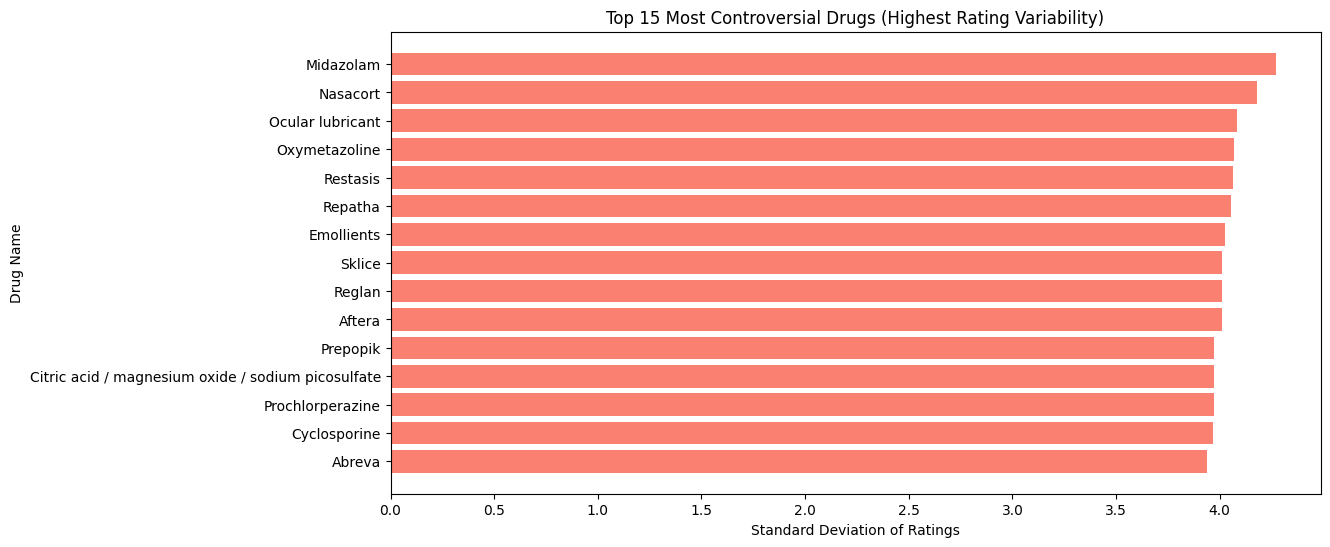

In [42]:
plt.figure(figsize=(12, 6))
plt.barh(controversial_drugs.index, controversial_drugs["std"], color='salmon')
plt.xlabel("Standard Deviation of Ratings")
plt.ylabel("Drug Name")
plt.title("Top 15 Most Controversial Drugs (Highest Rating Variability)")
plt.gca().invert_yaxis()  # Highest variability on top
plt.show()

### **Insights of the Most Controversial Drugs**
After investigating the common usages of these drugs, they are concentrated in several categories.
1. **Drugs with severe side effects** tend to be controversial.
2. **Chronic condition treatments** (e.g., Restasis, Repatha) are polarizing.
3. **Short-term, emergency-use drugs** (e.g., Aftera, Midazolam) get mixed reviews may depending on individual reactions and expectations.